In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# print(os.getcwd())
# os.chdir('../../')
# print(os.getcwd())



In [3]:
# base_input_dir = "inputs/train/"
# base_output_dir = "outputs/"

# base_test_score_path = "outputs/test_scores/"

In [4]:
base_input_dir = "/data/tasnina/drug-synergy-prediction/inputs/train/"
base_output_dir = "/data/tasnina/drug-synergy-prediction/outputs/"

base_test_score_path = "/data/tasnina/drug-synergy-prediction/outputs/test_scores/"

In [5]:
feature_types = ['only_MACCS', 'MACCS_Target']
model = 'SVR'

In [6]:
#cell lines having more than 2000 drugpairs in it 
list_of_cell_lines = ['NCI-H226', 'HCC-2998', 'MDA-MB-435', 
 'DIPG25', 'COLO 205', 'HCT-15', 'HOP-92', 'TK-10', 'U251', 'HL-60(TB)', 'CCRF-CEM', 'EKVX', 
 'NCI-H522', 'SW-620','MALME-3M', 'RPMI-8226','NCI-H322M','UO-31','MDA-MB-231', 'SK-MEL-5','HS 578T',
 'M14', 'T-47D', 'SR', 'SF-539', 'OVCAR-8','OVCAR-5', 'SK-OV-3', 'OVCAR-4', 'TMD8',
 'HOP-62', 'NCIH23', 'IGROV1', 'ACHN', 'MCF7','SNB-19', '786-0', 'MDA-MB-468', 'K-562', 'SF-268', 'KBM-7', 
 'KM12', 'SF-295','A498', 'HCT116', 'OVCAR3', 'CAKI-1', 'BT-549', 'UACC62', 
 'A549','NCI-H460','SN12C', 'MOLT-4', 'SNB-75', 'HT29', 'RXF 393', 'LOX IMVI' 'UACC-257', 'SK-MEL-28', 'DU-145']

In [7]:
def pearson_correlation_func(y_true, y_pred):
    pearsons_r, p_value = stats.pearsonr(y_true, y_pred)
    return pearsons_r

In [8]:
def plot_score(score_dict, score_type, kernel, cell_line, output_dir):
    #for kernel=kernel, cell line= cell_line plot the score_type(e.g. mse, r2, pearsons correlation)
    x = list(score_dict.keys())
    y = list(score_dict.values())
    plt.plot(x, y)
    plt.xlabel('C')
    plt.ylabel(score_type)
    
    title = score_type + ' vs C for '+ kernel + ' kernel in '+ cell_line 
    plt.title(title)
    
    file_name = output_dir + cell_line + '/' +  kernel + '_' + score_type + '_plot.pdf'
    
    plt.savefig(file_name, bbox_inches ="tight", format = 'pdf')
    print(file_name, ' saved')
    
    plt.show()
    plt.close()

In [9]:
def SVR_model(input_dir, output_dir, list_of_cell_lines ):
    scoring = {'r2': make_scorer(r2_score),'mean_squared_error':make_scorer(mean_squared_error),\
              'pearsons_correlation_score':make_scorer(pearson_correlation_func)}

    for cell_line in list_of_cell_lines:
        feature_file = input_dir+cell_line+'_features.tsv'
        label_file = input_dir+cell_line+'_labels.tsv'

        feature = pd.read_csv(feature_file,sep='\t').to_numpy()
        # print(feature, feature.shape)
        label = pd.read_csv(label_file,sep='\t')['Loewe'].to_numpy()
        # print(label, label.shape)

        X_train, X_test, y_train, y_test = train_test_split(
            feature, label, test_size=0.1, random_state=0)

        for k in ['poly', 'rbf', 'linear']:
            file_name = output_dir + cell_line + '/' +  k + '_r2_mse_pearsons_score.tsv'
            if(not os.path.exists(file_name)):
                os.makedirs(os.path.dirname(file_name), exist_ok=True)

                avg_r2_dict = {}
                avg_mse_dict = {}
                avg_pearsons_dict = {}
                for c in range(1,100,5):
                    SVR_model = SVR(C=c, epsilon=0.2, kernel = k)
                    scores = cross_validate(SVR_model, X_train,y_train, cv=5, scoring = scoring)
                    avg_r2 = np.average(scores['test_r2'])
                    avg_mse =  np.average(scores['test_mean_squared_error'])
                    avg_pearsons = np.average(scores['test_pearsons_correlation_score'])

                    avg_r2_dict[c] = avg_r2
                    avg_mse_dict[c] = avg_mse
                    avg_pearsons_dict[c] = avg_pearsons

                    print('r2 ',avg_r2)
                    print('mse ',avg_mse)
                    print('pearsons correlation  ', avg_pearsons)
                #save these dictionary values as a df in file
                r2_mse_pearsons_score_df = pd.concat([pd.Series(avg_r2_dict,name='r2'), \
                                              pd.Series(avg_mse_dict,name = 'mse'),\
                                              pd.Series(avg_pearsons_dict,name = 'pearsons')],axis=1)


                r2_mse_pearsons_score_df.to_csv(file_name, sep='\t')

            else:
                print(file_name + ' already exists')

            r2_mse_pearsons_score_df = pd.read_csv(file_name, sep='\t', index_col = 'Unnamed: 0')
    #         print(r2_rmse_score_df.head())
            avg_r2_dict = r2_mse_pearsons_score_df['r2'].to_dict()
    #         print(avg_r2_dict.keys())
            avg_mse_dict = r2_mse_pearsons_score_df['mse'].to_dict()
            avg_pearsons_dict = r2_mse_pearsons_score_df['pearsons'].to_dict()

            #plot and save rmse, r2 scores

            plot_score(avg_r2_dict, 'r2', k, cell_line, output_dir)
            plot_score(avg_mse_dict,'mse', k, cell_line, output_dir)
            plot_score(avg_pearsons_dict,'pearsons', k, cell_line, output_dir)



inputs/train//only_MACCS/ outputs//only_MACCS/SVR/
0.05056132135365081
220.22027429223854
0.3913354903580958
0.13195556754659102
201.0730869468889
0.4272292907794427
0.15013287553021765
196.81650357747742
0.4316124657017809
0.15889484735060572
194.74554408244074
0.43357500764206003
0.16116972845641547
194.17494217035465
0.4338245881433929
0.15999787303278457
194.42869681534665
0.4334601749988242
0.15875682348752518
194.75203227421724
0.43473916026423326
0.15490329279851428
195.691217732583
0.43490671044857504
0.15002353805327143
196.85804451396876
0.4350680963016879
0.14395139436450763
198.26977178502182
0.4347723384500714
0.13736995568279603
199.79276277746027
0.4344916019317481
0.1303465485250542
201.39142653187918
0.43397015045071513
0.12312419577440041
203.03232415576934
0.43347358311554735
0.11657804744628575
204.51781937978262
0.43338037158641446
0.11009616322076257
205.98497712358866
0.4332443765563439
0.10427666028949167
207.3092559346997
0.433381730420446
0.09894702244500864
2

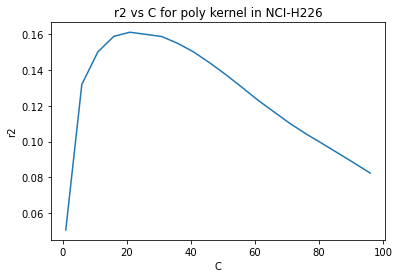

outputs//only_MACCS/SVR/NCI-H226/poly_mse_plot.pdf  saved


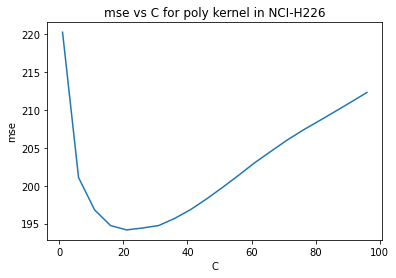

outputs//only_MACCS/SVR/NCI-H226/poly_pearsons_plot.pdf  saved


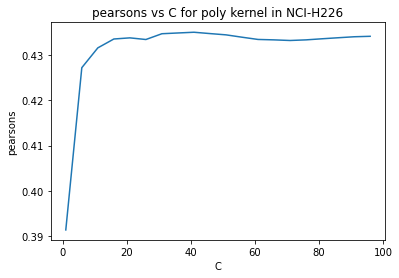

-0.0058106304135308266
233.3396720832539
0.3503568841003058
0.08781153439026053
211.55658807169812
0.421495259108238
0.12340603755724852
203.19853355846686
0.4367248340746602
0.14398127210597278
198.353519503271
0.4455327456139441
0.15698879986240818
195.30083205454378
0.45049583192019726
0.16544127669437114
193.30078757477406
0.453049102717703
0.17181229687297433
191.7868376090815
0.45423258730935884
0.17667142810879682
190.63625973718808
0.4551632195929816
0.1803930488599861
189.7604480290832
0.45569593920883655
0.18270238506382958
189.21642271942844
0.4555547932169758
0.18392978501777654
188.9237826258477
0.45506542741436984
0.18475545634310342
188.71393102454635
0.45471581191035515
0.1852839996837465
188.58572135345366
0.4545971714639065
0.18558339411570357
188.51832999463386
0.454547975748506
0.18550028841235405
188.5313398766645
0.4543757790098966
0.18499656955976945
188.64763872656468
0.4540340395103349
0.18414816090009006
188.8516740845511
0.45360031305792603
0.1832124898944997

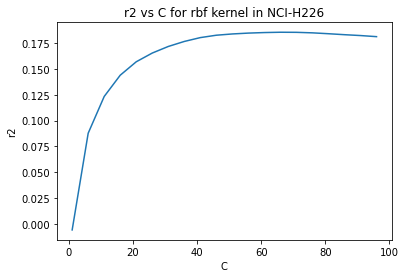

outputs//only_MACCS/SVR/NCI-H226/rbf_mse_plot.pdf  saved


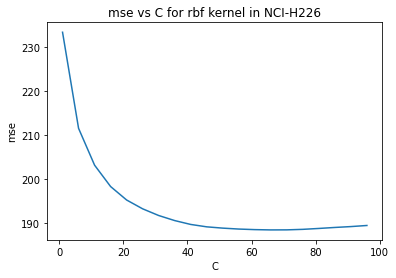

outputs//only_MACCS/SVR/NCI-H226/rbf_pearsons_plot.pdf  saved


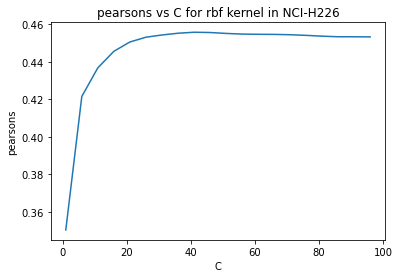

KeyboardInterrupt: 

In [11]:
for feature_combo in feature_types:
    input_dir = base_input_dir + '/' + feature_combo + '/'
    output_dir = base_output_dir + '/' + feature_combo + '/' + model +'/'
    
    print(input_dir, output_dir)
    SVR_model(input_dir, output_dir,list_of_cell_lines )

In [10]:
def find_best_c(file_name,metric):
    ##  metric is such that the lowest value => best model
    ## this function will output the value of c for which the chosen metric is the lowest. 
  
    score_df = pd.read_csv(file_name, sep='\t', index_col = 'Unnamed: 0')

    avg_metric_dict = score_df[metric].to_dict()
    
    index_with_min_value_for_metric = min(avg_metric_dict, key=avg_metric_dict.get)
    
    min_metric_val =avg_metric_dict[index_with_min_value_for_metric]
        
    return index_with_min_value_for_metric,  min_metric_val

In [11]:
def compute_test_score_SVR(input_dir, c, kernel):
# compute performance on the test dataset.
    feature_file = input_dir+cell_line+'_features.tsv'
    label_file = input_dir+cell_line+'_labels.tsv'

    feature = pd.read_csv(feature_file,sep='\t').to_numpy()
    label = pd.read_csv(label_file,sep='\t')['Loewe'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        feature, label, test_size=0.1, random_state=0)

    SVR_model = SVR(C=c, epsilon=0.2, kernel = kernel).fit(X_train, y_train)
    
    y_pred = SVR_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred, squared=True)
    r2 = r2_score(y_test, y_pred)
    pearsons = pearson_correlation_func(y_test, y_pred)
    
    return r2, mse, pearsons

In [12]:
#for each cell line find out the best hyperparameter and train model using those. 
#then compute performance on the test dataset.

for feature_combo in feature_types:
    input_dir = base_input_dir + '/' + feature_combo + '/'
    output_dir = base_output_dir + '/' + feature_combo + '/' + model +'/'
    
    test_score_file =  base_test_score_path + '/' + model + '_'+ feature_combo+'_test_score.tsv'
    
    all_cell_line_test_score_df= {}
    
    for cell_line in list_of_cell_lines:
        
        try: 
            best_c = 0
            best_kernel = 'linear'
            min_mse = 10000000000000

            for k in ['poly', 'rbf', 'linear']:
                file_name = output_dir + cell_line + '/' +  k + '_r2_mse_pearsons_score.tsv'
                print(file_name)
                c, mse = find_best_c(file_name,'mse')
                if(mse<min_mse):
                    min_mse=mse
                    best_kernel = k
                    best_c=c

            r2 , mse, pearsons =  compute_test_score_SVR (input_dir,best_c, best_kernel)
            all_cell_line_test_score_df[cell_line] = {'c': best_c, 'kernel': best_kernel,'min_5_fold_mse': min_mse,\
                                                      'r2' : r2, 'mse' : mse, 'pearsons' : pearsons}
            print(cell_line, all_cell_line_test_score_df[cell_line] )
        except:
            print('Cross-validation result not found for :' ,feature_combo, cell_line)
    df = pd.DataFrame.from_dict(all_cell_line_test_score_df, orient='index')
    
    os.makedirs(os.path.dirname(test_score_file), exist_ok=True)
    df.to_csv(test_score_file, sep = '\t')

/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/NCI-H226/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/NCI-H226/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/NCI-H226/linear_r2_mse_pearsons_score.tsv
NCI-H226 {'c': 66, 'kernel': 'rbf', 'min_5_fold_mse': 188.51832999463383, 'r2': 0.18317250426621134, 'mse': 145.34524336257482, 'pearsons': 0.46044318753563906}
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/HCC-2998/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/HCC-2998/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/HCC-2998/linear_r2_mse_pearsons_score.tsv
HCC-2998 {'c': 41, 'kernel': 'rbf', 'min_5_fold_mse': 213.0759018289549, 'r2': 0.2473649922132387, 'mse': 150.65819344607945, 'pearsons': 0.5109274193341975}
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/MDA-M

MDA-MB-231 {'c': 71, 'kernel': 'rbf', 'min_5_fold_mse': 155.0590698391943, 'r2': 0.18344724885615027, 'mse': 132.11498783585444, 'pearsons': 0.4571149754462068}
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/SK-MEL-5/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/SK-MEL-5/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/SK-MEL-5/linear_r2_mse_pearsons_score.tsv
SK-MEL-5 {'c': 46, 'kernel': 'rbf', 'min_5_fold_mse': 208.14306842158132, 'r2': 0.07915490637910316, 'mse': 212.93748976870148, 'pearsons': 0.36755929808292015}
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/HS 578T/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/HS 578T/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/HS 578T/linear_r2_mse_pearsons_score.tsv
HS 578T {'c': 51, 'kernel': 'rbf', 'min_5_fold_mse': 164.0050757674

786-0 {'c': 81, 'kernel': 'rbf', 'min_5_fold_mse': 189.17326264304646, 'r2': 0.08267073939997283, 'mse': 213.26070286258332, 'pearsons': 0.38492524943100104}
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/MDA-MB-468/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/MDA-MB-468/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/MDA-MB-468/linear_r2_mse_pearsons_score.tsv
MDA-MB-468 {'c': 41, 'kernel': 'rbf', 'min_5_fold_mse': 183.7740779111551, 'r2': 0.2243022886604895, 'mse': 159.21781219467277, 'pearsons': 0.4908761541707323}
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/K-562/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/K-562/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//only_MACCS/SVR/K-562/linear_r2_mse_pearsons_score.tsv
K-562 {'c': 36, 'kernel': 'rbf', 'min_5_fold_mse': 239.18905766962112, 

U251 {'c': 91, 'kernel': 'rbf', 'min_5_fold_mse': 189.9243272638729, 'r2': 0.38058872236488095, 'mse': 145.53184330580783, 'pearsons': 0.6211228023510343}
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/HL-60(TB)/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/HL-60(TB)/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/HL-60(TB)/linear_r2_mse_pearsons_score.tsv
HL-60(TB) {'c': 96, 'kernel': 'rbf', 'min_5_fold_mse': 288.1067278359688, 'r2': 0.21750516446895418, 'mse': 283.426813160938, 'pearsons': 0.4919173815430836}
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/CCRF-CEM/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/CCRF-CEM/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/CCRF-CEM/linear_r2_mse_pearsons_score.tsv
CCRF-CEM {'c': 96, 'kernel': 'rbf', 'min_5_fold_mse': 231.

OVCAR-5 {'c': 96, 'kernel': 'rbf', 'min_5_fold_mse': 202.78171582570468, 'r2': 0.2842019337015347, 'mse': 209.40065712025938, 'pearsons': 0.552831459510087}
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/SK-OV-3/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/SK-OV-3/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/SK-OV-3/linear_r2_mse_pearsons_score.tsv
SK-OV-3 {'c': 96, 'kernel': 'rbf', 'min_5_fold_mse': 199.6451763424831, 'r2': 0.10560775326006655, 'mse': 213.11107573868057, 'pearsons': 0.4045838660155387}
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/OVCAR-4/poly_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/OVCAR-4/rbf_r2_mse_pearsons_score.tsv
/data/tasnina/drug-synergy-prediction/outputs//MACCS_Target/SVR/OVCAR-4/linear_r2_mse_pearsons_score.tsv
OVCAR-4 {'c': 66, 'kernel': 'rbf', 'min_5_fold_mse': 141.70717491